In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook

import numpy as np
import scipy.linalg as la
import pandas as pd
import random

from matplotlib import pyplot as plt

import math

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [2]:
class Basic_fully_connected_Network(nn.Module):
    def __init__(self, input_size, layer_width, hidden_layers, output_size=2):
        super().__init__()
        self.first_layer = nn.Linear(input_size, layer_width)
        self.last_layer = nn.Linear(layer_width, output_size)
        self.layers = nn.ModuleList([nn.Linear(layer_width,layer_width) for i in range(hidden_layers)])


    def forward(self, x):

        x = F.relu(self.first_layer(x))
        for layer in self.layers:
            x = F.relu(layer(x))
        logits = self.last_layer(x)
        
        return logits.float()

In [3]:
def quick_train_neural_net(NET, parameter_file_name, epochs, batch_size, training_data_set, loss_function = nn.CrossEntropyLoss()):
    
    def train(model, x, y, optimizer, criterion):
        model.train()
        model.zero_grad()
        output = model(x)
        loss = criterion(output,y)
        loss.backward()
        optimizer.step()
        return loss, output
    
    def test(model, x, y, criterion):
        model.eval()
        with torch.no_grad():
            output = model(x)
            loss = criterion(output,y)
        return loss, output
    

    criterion = loss_function
    optimizer = torch.optim.Adam(NET.parameters(), lr = 0.0001)
    
    Accuracy_History = np.zeros(epochs)
    Loss_History = np.zeros(epochs)


    data_train = DataLoader(dataset = training_data_set, batch_size = batch_size, shuffle = True)  
              
    for epoch in tqdm(range(epochs),total = epochs):
        epoch_loss = 0
        acc = 0
        for bidx, batch in enumerate(data_train):
            x_train, y_train = batch['inp'], batch['oup']
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            y_train = y_train.flatten()
            loss, predictions = train(NET,x_train,y_train, optimizer, criterion)
            epoch_loss += loss
    
               
            for idx, i in enumerate(predictions):
                if i.argmax() == y_train[idx].item():
                    acc += 1
                    
        Accuracy_History[epoch] = (acc/len(training_data_set))
        Loss_History[epoch] = epoch_loss



    torch.save(NET.state_dict(), parameter_file_name)
    

              
    plt.title('Accuracy')
    plt.plot(Accuracy_History)
    plt.show()

    plt.title('Loss')
    plt.plot(Loss_History)

    plt.show()
    
    return Accuracy_History, Loss_History

In [4]:
class Basic_Classification_Dataset(Dataset):
    def __init__(self,data, mode = 'train'):
        self.mode = mode
        

        if self.mode == 'train':

            self.inp = data[:,:-1]
            self.oup = data[:,-1]
        else:
            self.inp = data
    def __len__(self):
        return len(self.inp)
    def __getitem__(self, idx):
        if self.mode == 'train':
            inpt  = torch.Tensor(self.inp[idx])
            oupt  = torch.Tensor([self.oup[idx]]).long()
            return { 'inp': inpt,
                     'oup': oupt,
            }
        else:
            inpt = torch.Tensor(self.inp[idx])
            return { 'inp': inpt
            }

In [19]:
class nonrandom_MIMO_Dataset(Dataset):
    def __init__(self,in_set,set_index,selection = 'all'):
        '''
        Creates a data set that outputs two data points simultatneously.
       
        Inputs:
            in_set:  The data set with k classes from which data point are to be drawn.
            set_index:  Structure containing k numpy arrays each containing the index
                        of all elements of in_set corresponding to that class
            portion_same_class:  The portion of the time the data set will return
                                    two data points from the same class
            portion_different_class:  The portion of the time the data set will return
                                    two data points from different classes
                                   
        Note that the remaining portion of outputs 1 - (portion_same_class + portion_different_class)
        the data set will output two identical data points.
        '''
        self.in_set = in_set  
        self.set_index = set_index
        self.class_number = len(self.set_index)
        self.class_sizes =  np.array([len(i) for i in self.set_index])
        self.class_ends = np.cumsum(self.class_sizes)
        self.class_begins = np.roll(self.class_ends,1)
        self.class_begins[0] = 0
        self.item_shape = self.in_set[0]['inp'].shape
        self.selection = selection
        self.output_shape = self.item_shape[0]*2
        self.half_output = self.item_shape[0]
        self.org_size = np.sum(self.class_sizes)
   
    def set_class(self,classes):
        self.selection = classes

   
    def __len__(self):
        if self.selection == 'all':
            return np.sum(self.class_sizes)**2
        else:
            return self.class_sizes[self.selection[0]]*self.class_sizes[self.selection[1]]
   
    def __getitem__(self, idx):
        inpt = torch.empty(self.output_shape)
        if self.selection == 'all':
            first_index = idx//self.org_size
            second_index = idx%self.org_size
            first_class = np.searchsorted(self.class_ends,first_index,side = 'right')
            first_inclass_index = first_index-self.class_begins[first_class]
            second_class = np.searchsorted(self.class_ends,second_index,side = 'right')
            second_inclass_index = second_index-self.class_begins[second_class]
        else:
            first_class = self.selection[0]
            second_class = self.selection[1]
            first_inclass_index = idx//self.class_sizes[self.selection[1]]
            second_inclass_index = idx%self.class_sizes[self.selection[1]]
           


        inpt[:self.half_output]=self.in_set[self.set_index[first_class][first_inclass_index]]['inp']
        inpt[self.half_output:]=self.in_set[self.set_index[second_class][second_inclass_index]]['inp']

        oupt = 1

        if first_class == second_class:
            oupt = 0


               
        return { 'inp': inpt,
                     'oup': oupt,
            }

In [24]:
class MIMO_Dataset(Dataset):
    def __init__(self,seperated_set,portion_same_class = 0.5, portion_different_class = 0.5):
        self.seperated_set = seperated_set   
        self.class_number = len(self.seperated_set)
        self.class_sizes = np.array([len(i) for i in self.seperated_set])
        self.item_shape = self.seperated_set[0].shape[1]
        self.output_shape = 2*self.item_shape
        self.portion_same_class = portion_same_class
        self.portion_different_class = portion_different_class
        self.duplication_percent = 1-(self.portion_same_class+self.portion_different_class)
    def __len__(self):
        return np.sum(self.class_sizes)
    def __getitem__(self, idx):
        inpt = np.empty(self.output_shape)
        oupt = 0
        random_choice = np.random.rand()
        if random_choice < self.portion_same_class:#draw from same class
            my_class = np.random.randint(self.class_number) 
            locations = np.random.randint(self.class_sizes[my_class],size = 2)
            inpt[:self.item_shape]=self.seperated_set[my_class][locations[0]]
            inpt[self.item_shape:]=self.seperated_set[my_class][locations[1]]
        elif random_choice < (self.portion_same_class+self.portion_different_class):   # draw from differnt classes        
            my_classes = np.random.choice(self.class_number, size = 2, replace=False) 
            location0 = np.random.randint(self.class_sizes[my_classes[0]],size = 1)
            location1 = np.random.randint(self.class_sizes[my_classes[1]],size = 1)
            inpt[:self.item_shape]=self.seperated_set[my_classes[0]][location0]
            inpt[self.item_shape:]=self.seperated_set[my_classes[1]][location1]
            oupt = 1
        else:  #duplicate element          
            my_class = np.random.randint(self.class_number)
            location = np.random.randint(self.class_sizes[my_class],size = 1)
            inpt[:self.item_shape]=self.seperated_set[my_class][location]
            inpt[self.item_shape:]=self.seperated_set[my_class][location]
            
        inpt = torch.tensor(inpt).float()       

            
        oupt = torch.Tensor(np.array([oupt])).long()
                
        return { 'inp': inpt,'oup': oupt}
    
    def get_specific(self, class1, class2, loc1, loc2):
        inpt = torch.empty(self.output_shape)
        inpt[:self.channels]=self.seperated_set[class1,loc1]
        inpt[self.channels:]=self.seperated_set[class2,loc2]

        return inpt

In [ ]:
def gradient_soft_labels(harmony_matrix, initialization_parameter = 1, penalty_constant=0, projection_type='shift_and_rescale', projection_frequency=0, norm_type = 'fro', learning_rate=0.01, iterations=10000, true_S = None, verbose = False):
    '''
    Returns a stochastic matrix S such that S^T S = H (the harmony_matrix input).
        Paramters:
            harmony_matrix (2 dimensional square numpy array): the Gram Matrix we wish to reconstruct
            initilization_parameter (int between 0 and 1): The gradient descent searh is intialized at initilization_parameter*I+(1-initilization_parameter)(ones matrix)/K
            penalty_constant (positive float or inf): Scales the penaltly term requiring iterates to be stochastic
            projection_type ('shift_and_rescale' or ...): determines the method of turning iterates into stochastic matrices
            projection_frequency (positive int):  Determines how often the iterates are turned stochastic (0 means this only happens once at the end)
            learning_rate (positive float): initial learning rate of the ADAM algorithm
            iterations (positive int): the number of interations to run the optimizer
            true_S (2 dimensional square numpy array): the true S matrix if known
            verbose (bool): whether the output includes lost histories and plots of the loss histories are produced
        Returns:
            If verbose == False returns the S
            If verbose == True returns the S and the history of ||\hat{S}^{T}\hat{S}-H|| (and ||S-\hat{S}|| there's a value for true_S)
    '''
    def relu_and_rescale(x):
        x[x<0] *= 0
        x /= torch.sum(x,dim = 0)
        return
        
    def shift_and_rescale(x):
        negs = torch.min(x,dim = 0)[0]
        negs[negs>0]*=0
        x -= negs
        x /= torch.sum(x,dim = 0)
        return

    def minimize_euclidean(x):
        size = x.shape[0]
        for j in range(size):
            sorted, unneeded = torch.sort(x[:,j])
            found = False
            for i in range(size-1,0,-1):
                t = (torch.sum(sorted[i:])-1)/(size-i)
                #print(t)
                #print(sorted[i])
                if t >= sorted[i]:
                    found = True
                    break
            if found == False:
                t = (torch.sum(x[:,j])-1)/size
            x[:,j] -= t
            x[:,j][x[:,j]<0]*=0
        return

    if projection_type=='shift_and_rescale':
        projector = shift_and_rescale
    elif projection_type=='minimize_euclidean':
        projector = minimize_euclidean
    else:
        #TODO implement error raise
        pass
        
    
    class_number = harmony_matrix.shape[0]
    H = torch.tensor(harmony_matrix)
    loss_history = torch.zeros(iterations+1)
    if not true_S is None:
        error_history = torch.zeros(iterations+1)
        truth = torch.tensor(true_S)

    S = initialization_parameter*torch.eye(class_number) + (1-initialization_parameter)* torch.ones((class_number,class_number))/class_number
    S.requires_grad = True

    
    if penalty_constant != 0:
        ones = torch.ones(class_number)

    #opt = torch.optim.Adam([S], lr=learning_rate)
    opt = torch.optim.SGD([S], lr=learning_rate)
    for i in tqdm(range(iterations)):
        #print(i)
        opt.zero_grad()
        loss = torch.norm(torch.matmul(torch.t(S),S)-H,p=norm_type)
        loss_history[i] += loss
        if not true_S is None:
            error_history[i] = torch.norm(S-truth,p='fro')
        if penalty_constant != 0:
            loss = loss + penalty_constant*(torch.norm(torch.matmul(torch.t(S),ones)-ones,p=1) - torch.sum(S[S<0]))
        loss.backward()
        opt.step()
        if projection_frequency!=0:
            if i%projection_frequency == 0:
                with torch.no_grad():
                    projector(S)
                        
    with torch.no_grad():
        projector(S)
        #Enforce diagonal dominance, Unstable
        new_order = [torch.argmax(S[:,i]).item() for i in range(class_number)]
        S = S[new_order]
        
    loss_history[-1] += torch.norm(torch.matmul(torch.t(S),S)-H,p=norm_type)
    loss_history = loss_history.detach().numpy()
    
    if not true_S is None:
        error_history[-1] += torch.norm(S-truth,p='fro')
        error_history = error_history.detach().numpy()

    S = S.detach().numpy()

    

    if verbose:
        plt.title('All Optimization Steps')
        plt.plot(loss_history,label = r'$||\hat{S}^{T}\hat{S}-H||$')
        if not true_S is None:
            plt.plot(error_history,label = r'$||S-\hat{S}||$')
        plt.legend()
        plt.show()

        if projection_frequency != 0:
            plt.title('Optimization Steps After Projection')
            plt.plot(loss_history[::projection_frequency],label = r'$||\hat{S}^{T}\hat{S}-H||$')
            if not true_S is None:
                plt.plot(error_history[::projection_frequency],label = r'$||S-\hat{S}||$')
            plt.legend()
            plt.show()

        print('Final loss value: '+str(loss_history[-1]))
            
        if not true_S is None:
            
            print('Final Forbenius norm error: '+str(error_history[-1]))
            print('Maximum single element deviation in final estimate: '+str(np.max(np.abs(S-true_S))))
            return S, loss_history, error_history

        return S, loss_history

    return S


    

In [ ]:
def create_index(data_set, class_number):
    index = [[] for i in range(class_number)]
    for i in range(len(data_set)):
        current_class = data_set[i][1]
        index[current_class].append(i)
    return index

In [7]:
german_data = pd.read_csv('data_folder/normalized_german_credit_data.csv')

In [8]:
german_array = german_data.to_numpy()
german_class0 = german_array[np.where(german_array[:,-1]==0)]
german_class1 = german_array[np.where(german_array[:,-1]==1)]

In [9]:
german_array

array([[ 0.26210365, -0.7310062 , -0.47729197, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.2402444 ,  0.21556222, -0.42921768, ...,  0.        ,
         0.        ,  0.        ],
       [-0.23243154, -0.5050849 , -0.39581221, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.72696672, -0.83071838, -0.43593575, ...,  0.        ,
         0.        ,  1.        ],
       [-0.23243154, -0.18607565,  0.39618093, ...,  0.        ,
         0.        ,  1.        ],
       [-0.72696672, -0.41548339, -0.28302252, ...,  0.        ,
         0.        ,  1.        ]])

In [10]:
german_class0

array([[ 0.26210365, -0.7310062 , -0.47729197, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.2402444 ,  0.21556222, -0.42921768, ...,  0.        ,
         0.        ,  0.        ],
       [-0.23243154, -0.5050849 , -0.39581221, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25117402,  1.71403406,  0.14902977, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01483606,  3.26584842,  0.37497894, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.26210365, -0.20734293, -0.32271463, ...,  1.        ,
         0.        ,  0.        ]])

In [11]:
full_dataset = Basic_Classification_Dataset(german_array)
class0_dataset = Basic_Classification_Dataset(german_class0)
class1_dataset = Basic_Classification_Dataset(german_class1)

In [62]:
my_model = Basic_fully_connected_Network(59,60,3).to(device)
my_model.eval()

Basic_fully_connected_Network(
  (first_layer): Linear(in_features=59, out_features=60, bias=True)
  (last_layer): Linear(in_features=60, out_features=2, bias=True)
  (layers): ModuleList(
    (0-2): 3 x Linear(in_features=60, out_features=60, bias=True)
  )
)

  0%|          | 0/1000 [00:00<?, ?it/s]

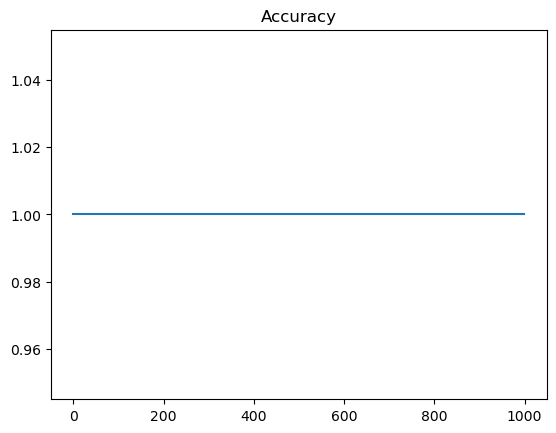

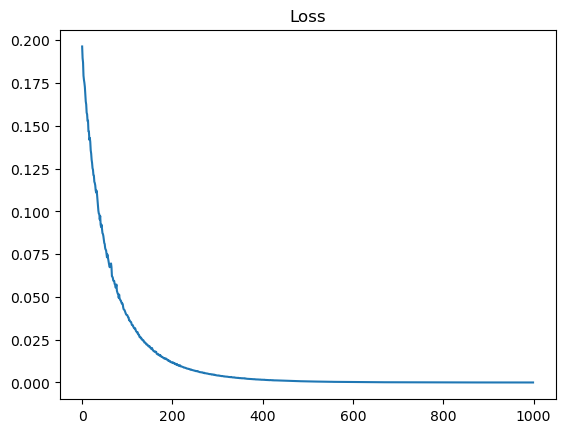

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 

In [67]:
quick_train_neural_net(my_model, 'German_3x60_1000e.pt', 1000, 64, full_dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

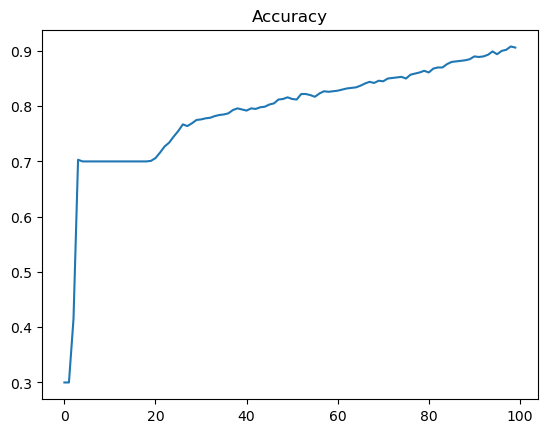

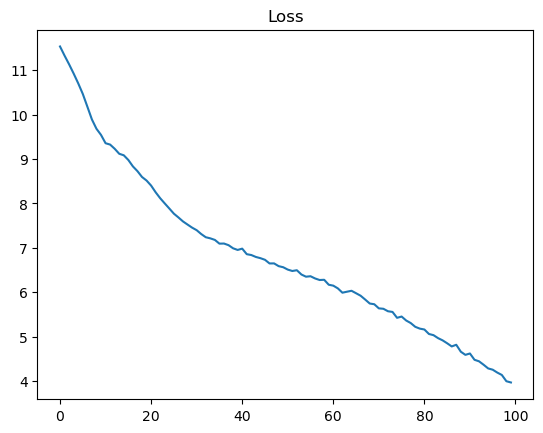

[[0.74735526 0.25264474]
 [0.13415634 0.86584365]]


  0%|          | 0/200 [00:00<?, ?it/s]

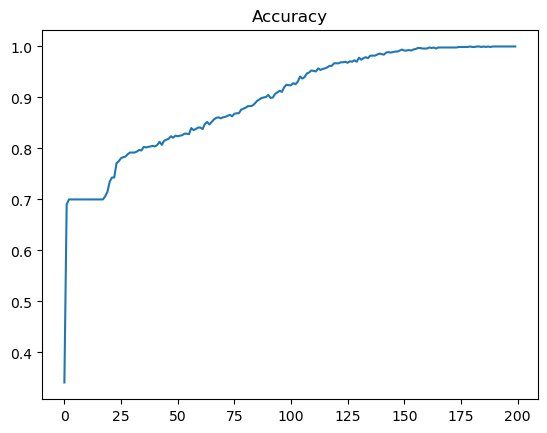

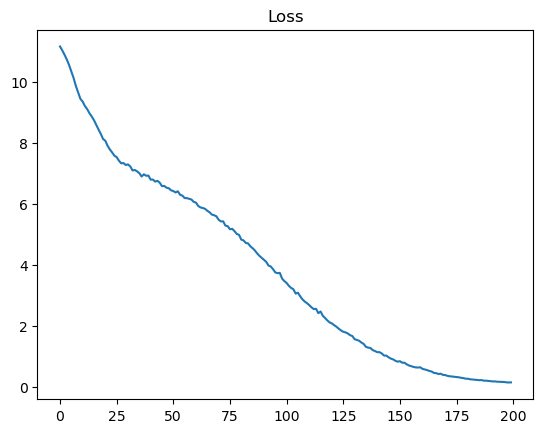

[[0.9817503  0.01824971]
 [0.00472095 0.99527905]]


  0%|          | 0/300 [00:00<?, ?it/s]

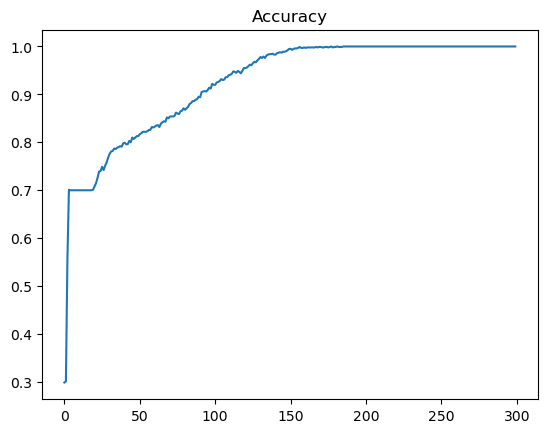

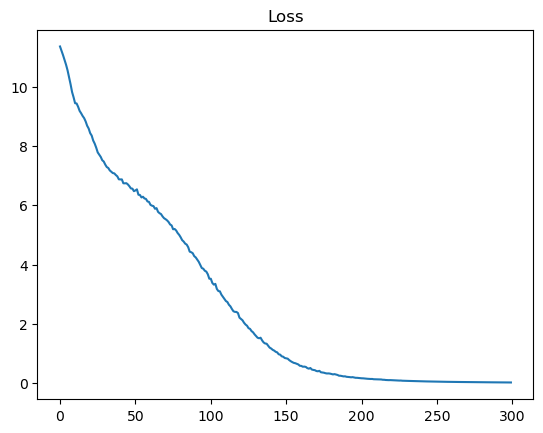

[[9.97931595e-01 2.06839951e-03]
 [7.82042279e-04 9.99217954e-01]]


  0%|          | 0/400 [00:00<?, ?it/s]

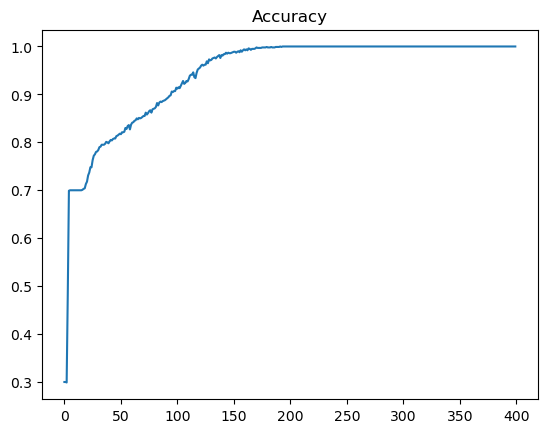

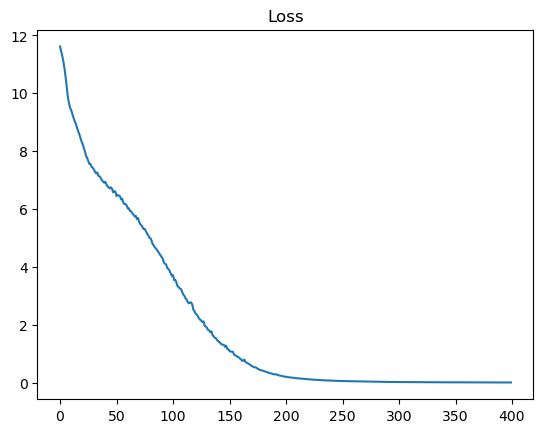

[[9.99489466e-01 5.10534427e-04]
 [1.96695730e-04 9.99803320e-01]]


In [14]:
for i in [100,200,300,400]:
    my_model = Basic_fully_connected_Network(59,60,3).to(device)
    my_model.eval()
    quick_train_neural_net(my_model, 'German_3x60_'+str(i)+'e.pt', i, 64, full_dataset)

    S = np.zeros((2,2))
    S_00 = 0 
    S_01 = 0 
    S_10 = 0 
    S_11 = 0 

    loader0 = DataLoader(dataset = class0_dataset, batch_size = 64, shuffle = False)  
    loader1 = DataLoader(dataset = class1_dataset, batch_size = 64, shuffle = False) 
    
    for bidx, batch in enumerate(loader0):
        #print(batch)
        x_val, y_val = batch['inp'], batch['oup']
        x_val = x_val.to(device)
        output = torch.nn.functional.softmax(my_model(x_val),dim = 1)
        S_00 +=  torch.sum(output[:,0]).item()
        S_01 +=  torch.sum(output[:,1]).item()
    S[0,0] = S_00/len(german_class0)
    S[0,1] = S_01/len(german_class0)

    for batch in loader1:
        x_val, y_val = batch['inp'], batch['oup']
        x_val = x_val.to(device)
        output = torch.nn.functional.softmax(my_model(x_val),dim = 1)
        S_10 +=  torch.sum(output[:,0]).item()
        S_11 +=  torch.sum(output[:,1]).item()
    S[1,0] = S_10/len(german_class1)
    S[1,1] = S_11/len(german_class1)

    print(S)





In [15]:
german_index = [np.where(german_array[:,-1] == 0)[0], np.where(german_array[:,-1] == 1)[0]]

In [20]:
german_diff_set = nonrandom_MIMO_Dataset(full_dataset,german_index)

In [25]:
german_rdiff_set = MIMO_Dataset([german_class0[:,:-1],german_class1[:,:-1]],portion_same_class = 0.5, portion_different_class = 0.5)

In [26]:
my_verifier = Basic_fully_connected_Network(118,60,3).to(device)
my_verifier.eval()

Basic_fully_connected_Network(
  (first_layer): Linear(in_features=118, out_features=60, bias=True)
  (last_layer): Linear(in_features=60, out_features=2, bias=True)
  (layers): ModuleList(
    (0-2): 3 x Linear(in_features=60, out_features=60, bias=True)
  )
)

  0%|          | 0/1000 [00:00<?, ?it/s]

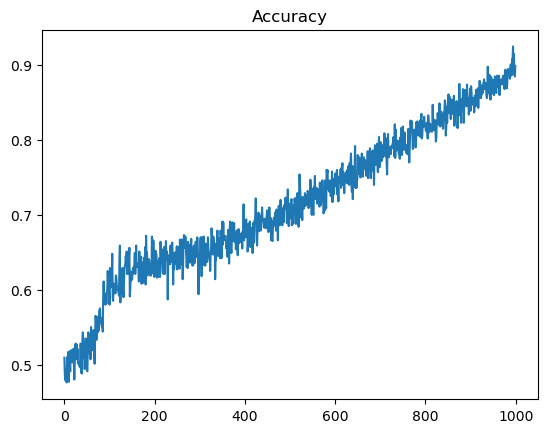

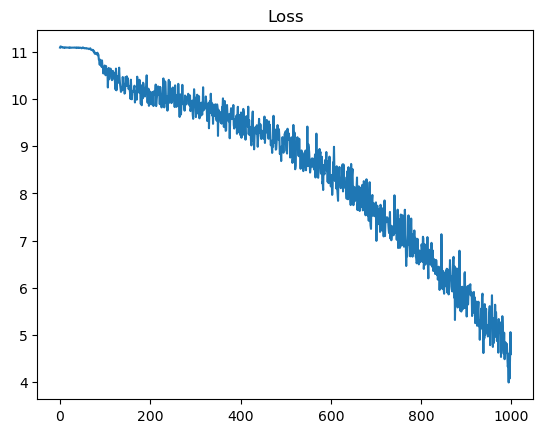

(array([0.509, 0.487, 0.479, 0.493, 0.49 , 0.476, 0.51 , 0.487, 0.504,
        0.517, 0.477, 0.514, 0.499, 0.491, 0.519, 0.506, 0.515, 0.519,
        0.503, 0.513, 0.521, 0.498, 0.48 , 0.505, 0.525, 0.528, 0.508,
        0.527, 0.507, 0.521, 0.502, 0.501, 0.503, 0.498, 0.5  , 0.496,
        0.528, 0.489, 0.505, 0.488, 0.533, 0.543, 0.509, 0.53 , 0.522,
        0.494, 0.505, 0.535, 0.527, 0.504, 0.492, 0.491, 0.528, 0.543,
        0.531, 0.515, 0.539, 0.536, 0.507, 0.55 , 0.543, 0.519, 0.526,
        0.543, 0.532, 0.546, 0.514, 0.501, 0.532, 0.565, 0.56 , 0.533,
        0.555, 0.542, 0.551, 0.564, 0.545, 0.572, 0.573, 0.575, 0.555,
        0.556, 0.562, 0.551, 0.559, 0.544, 0.591, 0.611, 0.588, 0.589,
        0.581, 0.58 , 0.595, 0.581, 0.595, 0.6  , 0.625, 0.609, 0.609,
        0.598, 0.58 , 0.629, 0.603, 0.605, 0.609, 0.612, 0.648, 0.59 ,
        0.585, 0.608, 0.606, 0.602, 0.606, 0.595, 0.619, 0.616, 0.606,
        0.603, 0.6  , 0.599, 0.596, 0.592, 0.64 , 0.659, 0.583, 0.627,
      

In [27]:
quick_train_neural_net(my_verifier, 'GermanV_3x60_1000e.pt', 1000, 64, german_rdiff_set)

  0%|          | 0/100 [00:00<?, ?it/s]

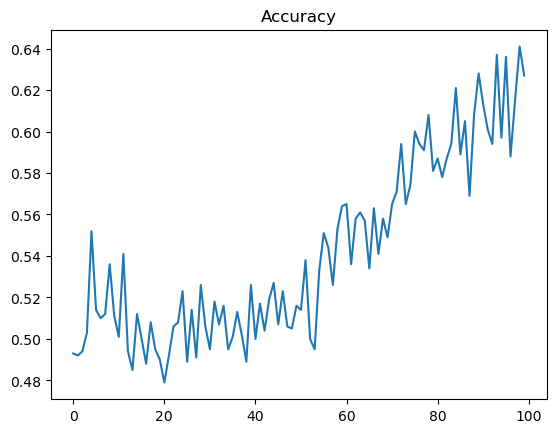

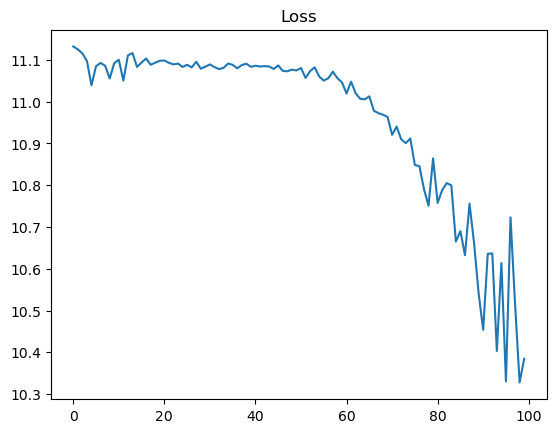

90000
490000
420000
[[0.52657246 0.46108193]
 [0.46108193 0.52459412]]


  0%|          | 0/1000 [00:00<?, ?it/s]

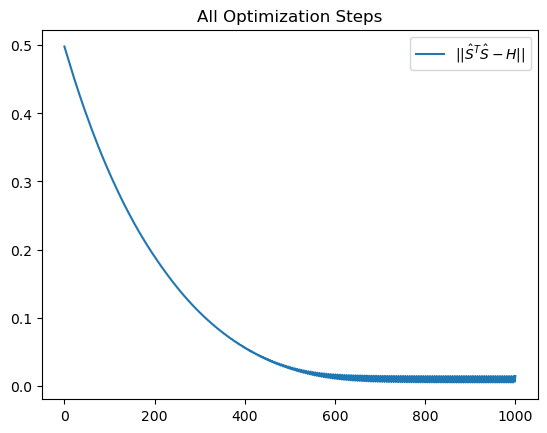

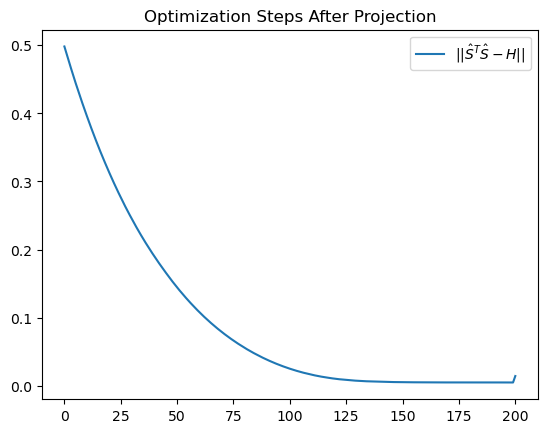

Final loss value: 0.014460417
[[0.6326155 0.3680842]
 [0.3673845 0.6319158]]


  0%|          | 0/200 [00:00<?, ?it/s]

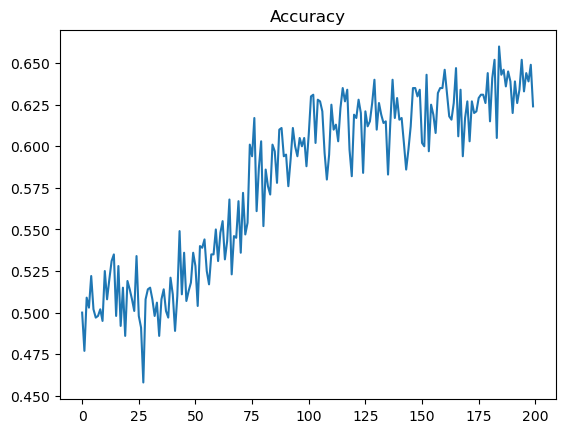

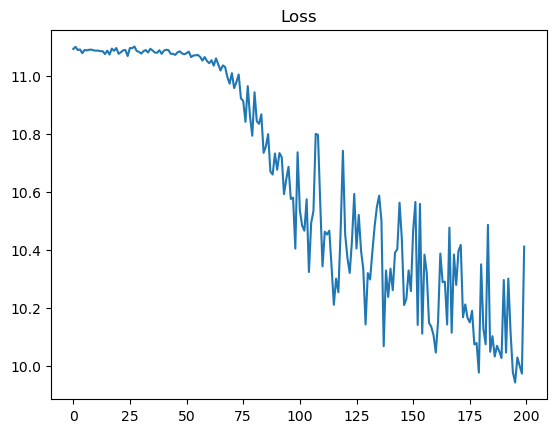

90000
490000
420000
[[0.5467692  0.43125506]
 [0.43125506 0.53690762]]


  0%|          | 0/1000 [00:00<?, ?it/s]

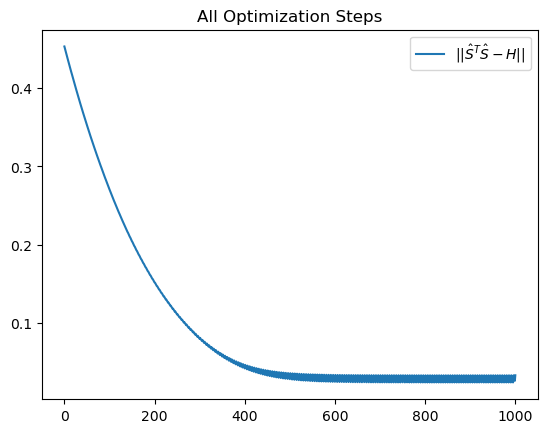

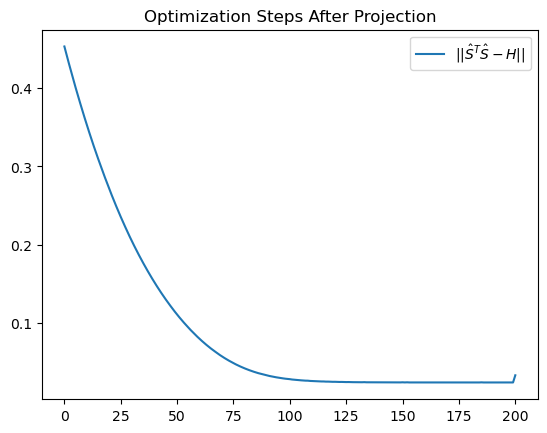

Final loss value: 0.033712987
[[0.6809049  0.32048434]
 [0.31909508 0.67951566]]


  0%|          | 0/300 [00:00<?, ?it/s]

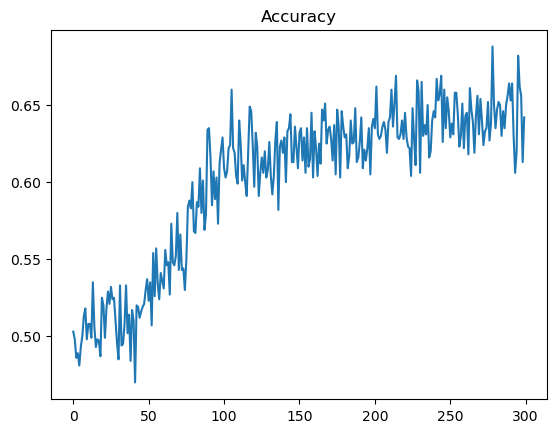

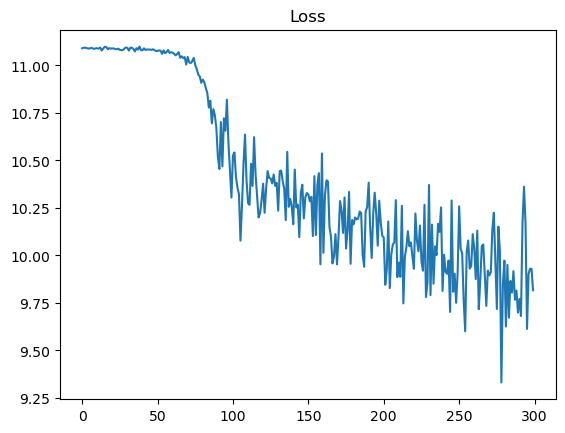

90000
490000
420000
[[0.57652917 0.43310141]
 [0.43310141 0.56102784]]


  0%|          | 0/1000 [00:00<?, ?it/s]

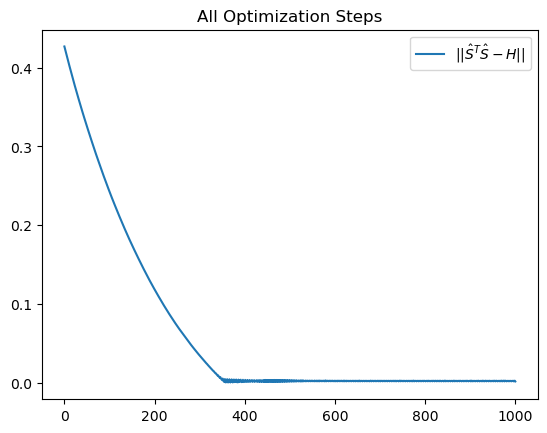

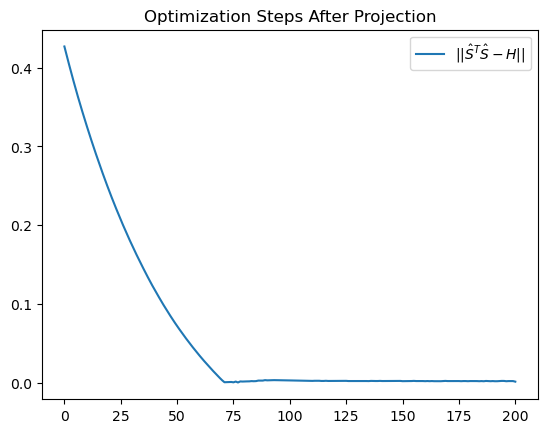

Final loss value: 0.0015066125
[[0.69429666 0.32610252]
 [0.3057033  0.67389745]]


  0%|          | 0/400 [00:00<?, ?it/s]

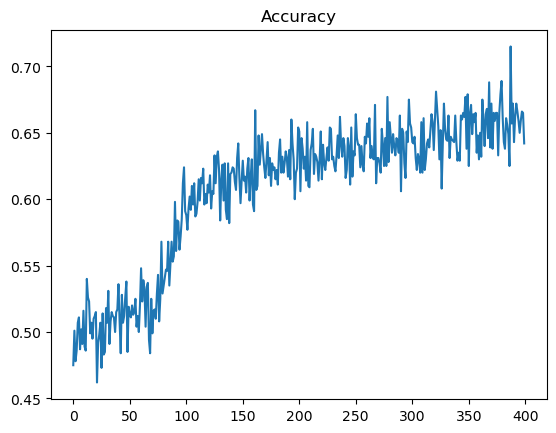

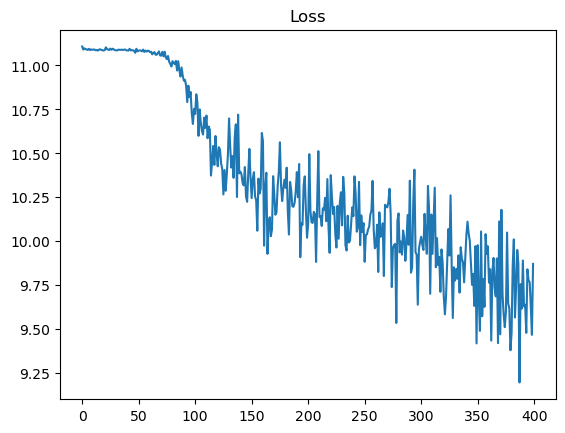

90000
490000
420000
[[0.58268844 0.42529744]
 [0.42529744 0.58599358]]


  0%|          | 0/1000 [00:00<?, ?it/s]

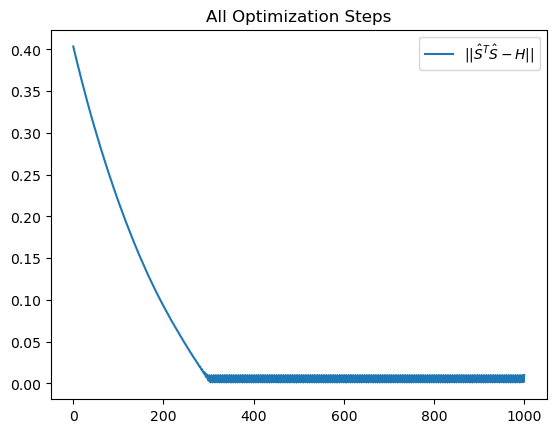

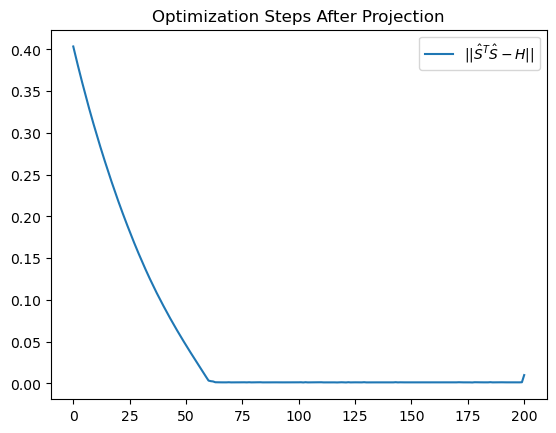

Final loss value: 0.009969688
[[0.6970182 0.3010333]
 [0.3029818 0.6989667]]


In [30]:
for i in [100,200,300,400]:
    my_model = Basic_fully_connected_Network(118,60,3).to(device)
    my_model.eval()
    quick_train_neural_net(my_model, 'GermanV_3x60_'+str(i)+'e.pt', i, 64, german_rdiff_set)

    G = np.zeros((2,2))
    G_00 = 0 
    G_01 = 0  
    G_11 = 0 

    loader = DataLoader(dataset = german_diff_set, batch_size = 64, shuffle = False)  

    german_diff_set.set_class([0,0])
    for bidx, batch in enumerate(loader):
        #print(batch)
        x_val, y_val = batch['inp'], batch['oup']
        x_val = x_val.to(device)
        output = torch.nn.functional.softmax(my_model(x_val),dim = 1)
        G_00 +=  torch.sum(output[:,0]).item()
    G[0,0] = G_00/len(german_diff_set)
    print(len(german_diff_set))

    german_diff_set.set_class([1,1])
    for bidx, batch in enumerate(loader):
        #print(batch)
        x_val, y_val = batch['inp'], batch['oup']
        x_val = x_val.to(device)
        output = torch.nn.functional.softmax(my_model(x_val),dim = 1)
        G_11 +=  torch.sum(output[:,0]).item()
    G[1,1] = G_11/len(german_diff_set)
    print(len(german_diff_set))

    german_diff_set.set_class([0,1])
    for bidx, batch in enumerate(loader):
        #print(batch)
        x_val, y_val = batch['inp'], batch['oup']
        x_val = x_val.to(device)
        output = torch.nn.functional.softmax(my_model(x_val),dim = 1)
        G_01 +=  torch.sum(output[:,0]).item()
    G[0,1] = G_01/len(german_diff_set)
    german_diff_set.set_class([1,0])
    for bidx, batch in enumerate(loader):
        #print(batch)
        x_val, y_val = batch['inp'], batch['oup']
        x_val = x_val.to(device)
        output = torch.nn.functional.softmax(my_model(x_val),dim = 1)
        G_01 +=  torch.sum(output[:,0]).item()
    G[0,1] = G_01/(2*len(german_diff_set))
    G[1,0] = G[0,1]
    print(2*len(german_diff_set))

    print(G)
    S,loss = gradient_soft_labels(G, initialization_parameter = 0.75, penalty_constant=0.1, projection_type='shift_and_rescale', projection_frequency=5, norm_type='fro', learning_rate=0.001, iterations=1000, true_S = None, verbose = True)
    print(S)

In [1]:
#Pytorch imports

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook

#Package for creating Actionable Counterfactuals

###import dice_ml as dml
###from dice_ml.explainer_interfaces.dice_pytorch import DicePyTorch
###from dice_ml.utils.exception import UserConfigValidationException

# Package for creating Adversarial Examples

###import art

#Package for creating amicable perturbations

#import amicable_pertubations as ap

#Miscellaneous Utilities 

import numpy as np
import scipy.linalg as la
import pandas as pd
import random

from matplotlib import pyplot as plt

import math

import Utils as ut

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [29]:
def gradient_soft_labels(harmony_matrix, initialization_parameter = 1, penalty_constant=0, projection_type='shift_and_rescale', projection_frequency=0, norm_type = 'fro', learning_rate=0.01, iterations=10000, true_S = None, verbose = False):
    '''
    Returns a stochastic matrix S such that S^T S = H (the harmony_matrix input).
        Paramters:
            harmony_matrix (2 dimensional square numpy array): the Gram Matrix we wish to reconstruct
            initilization_parameter (int between 0 and 1): The gradient descent searh is intialized at initilization_parameter*I+(1-initilization_parameter)(ones matrix)/K
            penalty_constant (positive float or inf): Scales the penaltly term requiring iterates to be stochastic
            projection_type ('shift_and_rescale' or ...): determines the method of turning iterates into stochastic matrices
            projection_frequency (positive int):  Determines how often the iterates are turned stochastic (0 means this only happens once at the end)
            learning_rate (positive float): initial learning rate of the ADAM algorithm
            iterations (positive int): the number of interations to run the optimizer
            true_S (2 dimensional square numpy array): the true S matrix if known
            verbose (bool): whether the output includes lost histories and plots of the loss histories are produced
        Returns:
            If verbose == False returns the S
            If verbose == True returns the S and the history of ||\hat{S}^{T}\hat{S}-H|| (and ||S-\hat{S}|| there's a value for true_S)
    '''
    def relu_and_rescale(x):
        x[x<0] *= 0
        x /= torch.sum(x,dim = 0)
        return
        
    def shift_and_rescale(x):
        negs = torch.min(x,dim = 0)[0]
        negs[negs>0]*=0
        x -= negs
        x /= torch.sum(x,dim = 0)
        return

    def minimize_euclidean(x):
        size = x.shape[0]
        for j in range(size):
            sorted, unneeded = torch.sort(x[:,j])
            found = False
            for i in range(size-1,0,-1):
                t = (torch.sum(sorted[i:])-1)/(size-i)
                #print(t)
                #print(sorted[i])
                if t >= sorted[i]:
                    found = True
                    break
            if found == False:
                t = (torch.sum(x[:,j])-1)/size
            x[:,j] -= t
            x[:,j][x[:,j]<0]*=0
        return

    if projection_type=='shift_and_rescale':
        projector = shift_and_rescale
    elif projection_type=='minimize_euclidean':
        projector = minimize_euclidean
    else:
        #TODO implement error raise
        pass
        
    
    class_number = harmony_matrix.shape[0]
    H = torch.tensor(harmony_matrix)
    loss_history = torch.zeros(iterations+1)
    if not true_S is None:
        error_history = torch.zeros(iterations+1)
        truth = torch.tensor(true_S)

    S = initialization_parameter*torch.eye(class_number) + (1-initialization_parameter)* torch.ones((class_number,class_number))/class_number
    S.requires_grad = True

    
    if penalty_constant != 0:
        ones = torch.ones(class_number)

    #opt = torch.optim.Adam([S], lr=learning_rate)
    opt = torch.optim.SGD([S], lr=learning_rate)
    for i in tqdm(range(iterations)):
        #print(i)
        opt.zero_grad()
        loss = torch.norm(torch.matmul(torch.t(S),S)-H,p=norm_type)
        loss_history[i] += loss
        if not true_S is None:
            error_history[i] = torch.norm(S-truth,p='fro')
        if penalty_constant != 0:
            loss = loss + penalty_constant*(torch.norm(torch.matmul(torch.t(S),ones)-ones,p=1) - torch.sum(S[S<0]))
        loss.backward()
        opt.step()
        if projection_frequency!=0:
            if i%projection_frequency == 0:
                with torch.no_grad():
                    projector(S)
                        
    with torch.no_grad():
        projector(S)
        #Enforce diagonal dominance, Unstable
        new_order = [torch.argmax(S[:,i]).item() for i in range(class_number)]
        S = S[new_order]
        
    loss_history[-1] += torch.norm(torch.matmul(torch.t(S),S)-H,p=norm_type)
    loss_history = loss_history.detach().numpy()
    
    if not true_S is None:
        error_history[-1] += torch.norm(S-truth,p='fro')
        error_history = error_history.detach().numpy()

    S = S.detach().numpy()

    

    if verbose:
        plt.title('All Optimization Steps')
        plt.plot(loss_history,label = r'$||\hat{S}^{T}\hat{S}-H||$')
        if not true_S is None:
            plt.plot(error_history,label = r'$||S-\hat{S}||$')
        plt.legend()
        plt.show()

        if projection_frequency != 0:
            plt.title('Optimization Steps After Projection')
            plt.plot(loss_history[::projection_frequency],label = r'$||\hat{S}^{T}\hat{S}-H||$')
            if not true_S is None:
                plt.plot(error_history[::projection_frequency],label = r'$||S-\hat{S}||$')
            plt.legend()
            plt.show()

        print('Final loss value: '+str(loss_history[-1]))
            
        if not true_S is None:
            
            print('Final Forbenius norm error: '+str(error_history[-1]))
            print('Maximum single element deviation in final estimate: '+str(np.max(np.abs(S-true_S))))
            return S, loss_history, error_history

        return S, loss_history

    return S


    

In [3]:
class MIMO_Dataset(Dataset):
    def __init__(self,seperated_set,portion_same_class = 0.5, portion_different_class = 0.5, random = True):
        self.seperated_set = seperated_set   
        self.class_number = len(self.seperated_set)
        self.class_sizes = np.array([len(i) for i in self.seperated_set])
        self.item_shape = self.seperated_set[0].shape[1]
        self.output_shape = 2*self.item_shape
        self.portion_same_class = portion_same_class
        self.portion_different_class = portion_different_class
        self.duplication_percent = 1-(self.portion_same_class+self.portion_different_class)
        self.random = random
        self.org_size = np.sum(self.class_sizes)
        self.class_ends = np.cumsum(self.class_sizes)
        self.class_begins = np.roll(self.class_ends,1)
        self.class_begins[0] = 0
    def __len__(self):
        if self.random:
            return self.org_size
        else:
            return self.org_size**2
    def __getitem__(self, idx):
        inpt = np.empty(self.output_shape)
        oupt = 0
        if self.random:
            random_choice = np.random.rand()
            if random_choice < self.portion_same_class:#draw from same class
                my_class = np.random.randint(self.class_number) 
                locations = np.random.randint(self.class_sizes[my_class],size = 2)
                inpt[:self.item_shape]=self.seperated_set[my_class][locations[0]]
                inpt[self.item_shape:]=self.seperated_set[my_class][locations[1]]
            elif random_choice < (self.portion_same_class+self.portion_different_class):   # draw from differnt classes        
                my_classes = np.random.choice(self.class_number, size = 2, replace=False) 
                location0 = np.random.randint(self.class_sizes[my_classes[0]],size = 1)
                location1 = np.random.randint(self.class_sizes[my_classes[1]],size = 1)
                inpt[:self.item_shape]=self.seperated_set[my_classes[0]][location0]
                inpt[self.item_shape:]=self.seperated_set[my_classes[1]][location1]
                oupt = 1
            else:  #duplicate element          
                my_class = np.random.randint(self.class_number)
                location = np.random.randint(self.class_sizes[my_class],size = 1)
                inpt[:self.item_shape]=self.seperated_set[my_class][location]
                inpt[self.item_shape:]=self.seperated_set[my_class][location]
        else:
            first_index = idx//self.org_size
            second_index = idx%self.org_size
            first_class = np.searchsorted(self.class_ends,first_index,side = 'right')
            first_inclass_index = first_index-self.class_begins[first_class]
            second_class = np.searchsorted(self.class_ends,second_index,side = 'right')
            second_inclass_index = second_index-self.class_begins[second_class]
            inpt[:self.item_shape]=self.seperated_set[first_class][first_inclass_index]
            inpt[self.item_shape:]=self.seperated_set[second_class][second_inclass_index]
            if first_class != second_class:
                oupt =1
                
        inpt = torch.tensor(inpt).float()       
    
                
        oupt = torch.Tensor(np.array([oupt])).long()
                    
        return { 'inp': inpt,'oup': oupt}
    
    def get_specific(self, class1, class2, loc1, loc2):
        inpt = torch.empty(self.output_shape)
        inpt[:self.channels]=self.seperated_set[class1,loc1]
        inpt[self.channels:]=self.seperated_set[class2,loc2]

        return inpt

In [5]:
def make_comparison(data_file,classifier_file,verifier_file,name,enhanced = False, calculate = True, subsample=False):
    data = pd.read_csv(data_file)
    data_array = data.to_numpy()
    if subsample == True:
        data_array = data_array[10::50,:]
    input_size = data_array.shape[1]
    sorted_array = [data_array[np.where(data_array[:,-1]==0)],data_array[np.where(data_array[:,-1]==1)]]
    class_size_1 = sorted_array[0].shape[0]
    class_size_2 = sorted_array[1].shape[0]
    total = class_size_1+class_size_2
    full_array = np.concatenate ((sorted_array[0],sorted_array[1]))
    dataset = ut.Basic_Classification_Dataset(full_array)
    print('priors =('+str(class_size_1/total)+','+str(class_size_2/total)+')')

    data_loader = DataLoader(dataset = dataset, batch_size = 64, shuffle = False)

    if calculate:
    
        if enhanced:
            class_logits = ut.Enhanced_fully_connected_Network(input_size-1,2)
        else:
            class_logits = ut.Basic_fully_connected_Network(input_size-1,2)
        
        class_logits.eval()
        class_logits.load_state_dict(torch.load(classifier_file))
        classifier = ut.softmaxed_network(class_logits).to(device)
    
        classifier_outputs = np.empty((total,2))
    
        
    
        for bidx, batch in tqdm(enumerate(data_loader),total = len(data_loader)):
            #print(classifier(batch['inp']).shape)
            classifier_outputs[bidx*64:(bidx+1)*64,:] = classifier(batch['inp'].to(device).float()).cpu().detach().numpy()
    
        np.save(name+'_classifier_outputs.npy',classifier_outputs)

    else:

        classifier_outputs = np.load(name+'_classifier_outputs.npy')

        

    class_1_accuracy = np.sum(classifier_outputs[:class_size_1,0]>=0.5)/class_size_1
    class_2_accuracy = np.sum(classifier_outputs[class_size_1:,1]>=0.5)/class_size_2
    print('Accuracy for class 1: '+str(class_1_accuracy))
    print('Accuracy for class 2: '+str(class_2_accuracy))
    print('Overall Accuracy: '+str((class_1_accuracy*class_size_1+class_2_accuracy*class_size_2)/total))
    
    S_c = np.zeros((2,2))
    S_c[0,0] = np.mean(classifier_outputs[:class_size_1,0])
    S_c[1,0] = np.mean(classifier_outputs[:class_size_1,1])
    S_c[0,1] = np.mean(classifier_outputs[class_size_1:,0])
    S_c[1,1] = np.mean(classifier_outputs[class_size_1:,1])

    diff_dataset = MIMO_Dataset([sorted_array[0][:,:-1],sorted_array[1][:,:-1]],portion_same_class = 0.5, portion_different_class = 0.5,random = False)

    if calculate:
    
        if enhanced:
            ver_logits = ut.Enhanced_fully_connected_Network((input_size-1)*2,2)
        else:
            ver_logits = ut.Basic_fully_connected_Network((input_size-1)*2,2)
        
        ver_logits.eval()
        ver_logits.load_state_dict(torch.load(verifier_file))
        verifier = ut.softmaxed_network(ver_logits).to(device)
    
        verifier_outputs = np.empty((total**2,2))
    
        diff_loader = DataLoader(dataset = diff_dataset, batch_size = 64, shuffle = False)
    
        for bidx, batch in tqdm(enumerate(diff_loader),total = len(diff_loader)):
            #print(classifier(batch['inp']).shape)
            verifier_outputs[bidx*64:(bidx+1)*64,:] = verifier(batch['inp'].to(device).float()).cpu().detach().numpy()
    
        verifier_outputs = verifier_outputs.reshape((total,total,2))

        np.save(name+'_verifier_outputs.npy',verifier_outputs)

    else: 
        
        verifier_outputs = np.load(name+'_verifier_outputs.npy')
        print()
    

    #plt.imshow(verifier_outputs[:,:,0])
    #plt.show()

    same_accuracy = (np.sum(verifier_outputs[:class_size_1,:class_size_1,0]>=0.5)+np.sum(verifier_outputs[class_size_1:,class_size_1:,0]>=0.5))/(class_size_1**2+class_size_2**2)
    diff_accuracy = (np.sum(verifier_outputs[:class_size_1,class_size_1:,1]>=0.5)+np.sum(verifier_outputs[class_size_1:,:class_size_1,1]>=0.5))/(class_size_1*class_size_2*2)
    print('Accuracy for same classes: '+str(same_accuracy))
    print('Accuracy for different classes: '+str(diff_accuracy))
    print('Overall Accuracy: '+str((same_accuracy*(class_size_1**2+class_size_2**2)+diff_accuracy*(class_size_1*class_size_2*2))/(total**2)))
    
    G = np.zeros((2,2))
    G[0,0] = np.mean(verifier_outputs[:class_size_1,:class_size_1,0])
    G[1,0] = np.mean(verifier_outputs[:class_size_1,class_size_1:,0])
    G[0,1] = np.mean(verifier_outputs[class_size_1:,:class_size_1,0])
    G[1,1] = np.mean(verifier_outputs[class_size_1:,class_size_1:,0])

    G = (G+G.T)/2

    #print('Raw G')
    #print(np.round(G,5))

    G = G/np.sum(G,axis = 1)

    print('G form verifier')
    print(np.round(G,5))

    G_c = np.dot(S_c.T,S_c)

    print('G from classifier')
    print(np.round(G_c,5))

    print('Difference in Gs: '+str(np.linalg.norm(G-G_c,ord = 'fro')))


    S,loss = gradient_soft_labels(G, initialization_parameter = 0.75, penalty_constant=0.1, projection_type='shift_and_rescale', projection_frequency=5, norm_type='fro', learning_rate=0.001, iterations=1000, true_S = None, verbose = True)

    print('S from verifier')
    print(np.round(S,5))
    
    print('S from classifier')
    print(np.round(S_c,5))

    PBER_v = 1 - (S[0,0]*(class_size_1/total) + S[1,1]*(class_size_2/total))
    print('PBER from verifier: '+str(PBER_v))

    PBER_c = 1 - (S_c[0,0]*(class_size_1/total) + S_c[1,1]*(class_size_2/total))
    print('PBER from classifier: '+str(PBER_c))

    print('Difference in ss: '+str(np.linalg.norm(S-S_c,ord = 'fro')))

    

priors =(0.3,0.7)


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy for class 1: 0.83
Accuracy for class 2: 0.8128571428571428
Overall Accuracy: 0.818


  0%|          | 0/15625 [00:00<?, ?it/s]

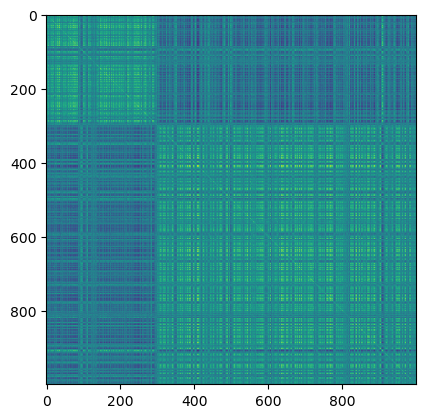

Accuracy for same classes: 0.5901689655172414
Accuracy for different classes: 0.6434261904761904
Overall Accuracy: 0.612537
G form verifier
[[0.55432 0.45163]
 [0.44568 0.54837]]
G from classifier
[[0.59922 0.40543]
 [0.40543 0.59014]]
Difference in Gs: 0.08669268782901676


  0%|          | 0/1000 [00:00<?, ?it/s]

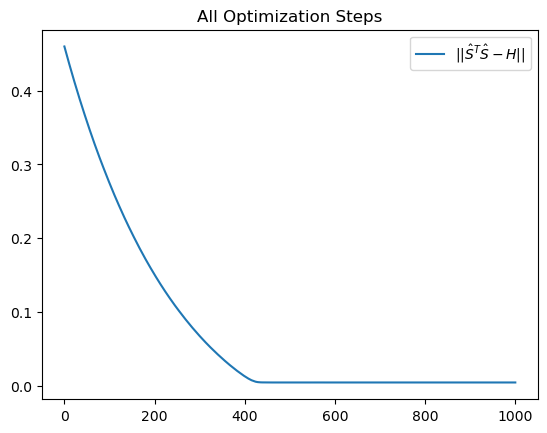

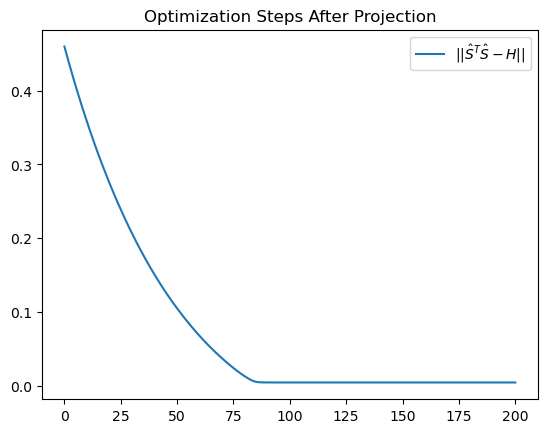

Final loss value: 0.004207776
S from verifier
[[0.66476 0.34428]
 [0.33524 0.65572]]
S from classifier
[[0.72273 0.2877 ]
 [0.27727 0.7123 ]]
PBER from verifier: 0.34156960248947144
PBER from classifier: 0.2845743415616453
Difference in ss: 0.11455381618188058


In [5]:
make_comparison('data_folder/normalized_german_credit_data.csv','models_folder/german_classifier.pt','models_folder/german_verifier.pt','German',enhanced = True)

In [ ]:
make_comparison('data_folder/normalized_german_credit_data.csv','models_folder/german_classifier.pt','models_folder/german_verifier.pt','German',enhanced = True, calculate = False)

In [ ]:

make_comparison('data_folder/numerisized_adult_income_data.csv','models_folder/adult_classifier.pt','models_folder/adult_verifier.pt','Adult_Income',calculate = False)


priors =(0.7609029484029484,0.2390970515970516)
Accuracy for class 1: 0.7561553985872855
Accuracy for class 2: 0.8574181117533719
Overall Accuracy: 0.7803670147420148


priors =(0.11157517899761336,0.8884248210023866)
Accuracy for class 1: 0.7984368572603867
Accuracy for class 2: 0.7575554063129617
Overall Accuracy: 0.7621167615201028

Accuracy for same classes: 0.7128782728868734
Accuracy for different classes: 0.6125789568608552
Overall Accuracy: 0.6929937011053896
G form verifier
[[0.55758 0.4196 ]
 [0.44242 0.5804 ]]
G from classifier
[[0.58694 0.42727]
 [0.42727 0.56085]]
Difference in Gs: 0.039153397797222315


  0%|          | 0/1000 [00:00<?, ?it/s]

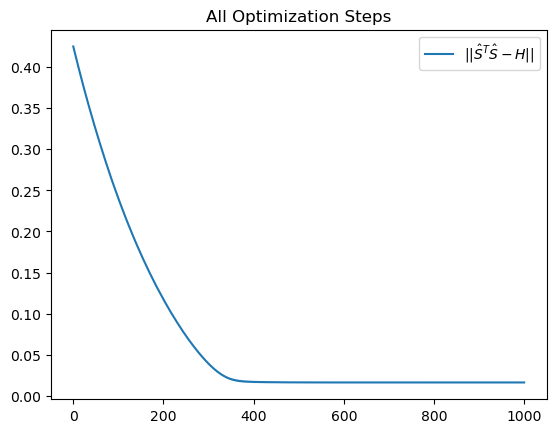

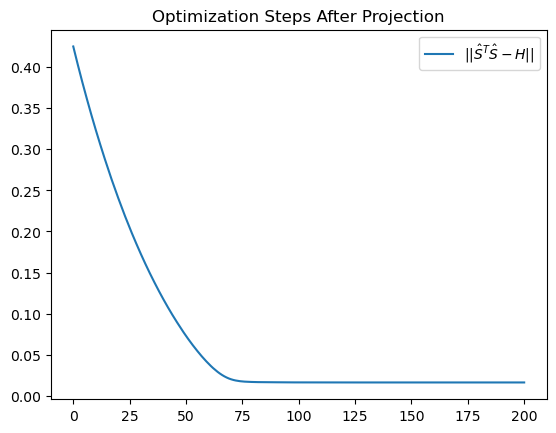

Final loss value: 0.016173119
S from verifier
[[0.67091 0.29924]
 [0.32909 0.70076]]
S from classifier
[[0.70849 0.32557]
 [0.29151 0.67443]]
PBER from verifier: 0.302567515673387
PBER from classifier: 0.3217711559322336
Difference in ss: 0.06490226093869554


In [6]:

make_comparison('data_folder/law_school_admissions_numeric_data.csv','models_folder/law_school_classifier.pt','models_folder/law_school_verifier.pt','law_school',calculate=False)


In [ ]:

make_comparison('data_folder/daibetes_predictors_numerisized_data.csv','models_folder/diabetes_classifier.pt','models_folder/diabetes_verifier.pt','diabetes',subsample = True)


priors =(0.9821999087174806,0.017800091282519397)


  0%|          | 0/35 [00:00<?, ?it/s]

Accuracy for class 1: 0.7481412639405205
Accuracy for class 2: 0.6923076923076923
Overall Accuracy: 0.747147421268827


  0%|          | 0/75008 [00:00<?, ?it/s]

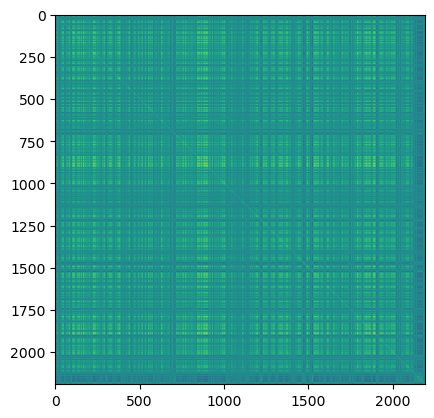

Accuracy for same classes: 0.5522978872669383
Accuracy for different classes: 0.6054236965017634
Overall Accuracy: 0.5541555106665353
G form verifier
[[0.53298 0.47834]
 [0.46702 0.52166]]
G from classifier
[[0.70612 0.46034]
 [0.46034 0.37321]]
Difference in Gs: 0.22888187484872932


  0%|          | 0/1000 [00:00<?, ?it/s]

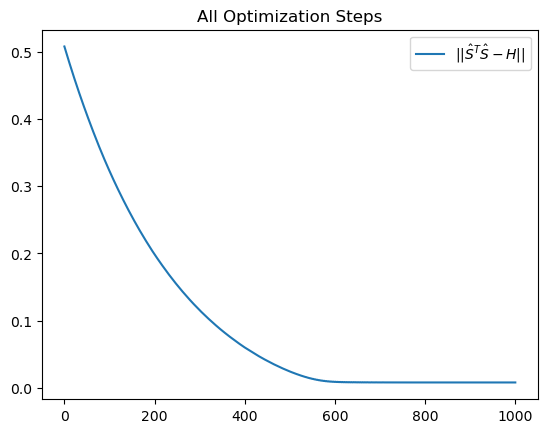

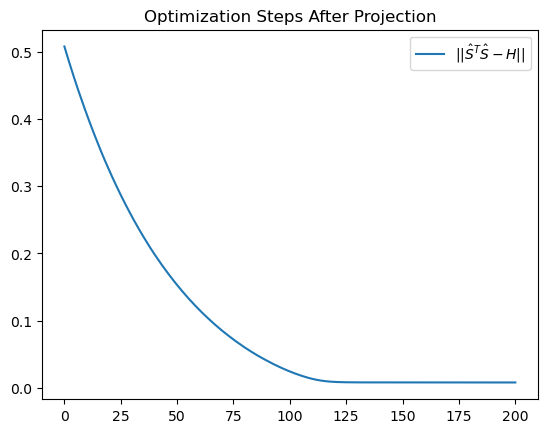

Final loss value: 0.008025525
S from verifier
[[0.62871 0.3947 ]
 [0.37129 0.6053 ]]
S from classifier
[[0.69683 0.30317]
 [0.46963 0.53037]]
PBER from verifier: 0.3717103445437443
PBER from classifier: 0.30613336813373004
Difference in Gs: 0.16823320732097988


In [15]:

make_comparison('data_folder/daibetes_predictors_numerisized_data.csv','models_folder/diabetes_classifier.pt','models_folder/diabetes_verifier.pt','diabetes',subsample = True)


In [ ]:
large = np.load('Adult_Income_verifier_outputs.npy')

In [ ]:
large.shape

In [ ]:
plt.imshow(large[::2,::2,0])
plt.show()

In [4]:
adult_income_data = pd.read_csv('data_folder/numerisized_adult_income_data.csv')

In [5]:
adult_income_array = adult_income_data.to_numpy()

In [6]:
all_adult_dataset = ut.Basic_Classification_Dataset(adult_income_array)

In [7]:
adult_training_dataset, adult_testing_dataset, adult_validation_dataset = ut.get_datasets_from_dataframe(adult_income_data)

In [8]:
classifier_for_softening = ut.Basic_fully_connected_Network(27,2)
classifier_for_softening.eval()

Basic_fully_connected_Network(
  (layer1): Linear(in_features=27, out_features=60, bias=True)
  (layer2): Linear(in_features=60, out_features=60, bias=True)
  (layer3): Linear(in_features=60, out_features=60, bias=True)
  (layer4): Linear(in_features=60, out_features=2, bias=True)
)

In [9]:
classifier_for_softening.load_state_dict(torch.load('models_folder/adult_classifier.pt'))

<All keys matched successfully>

In [10]:
soft_classifier = ut.softmaxed_network(classifier_for_softening).to(device)

In [11]:
ut.check_net_accuracy(soft_classifier, all_adult_dataset, 64, verbose = True)

100%|████████████████████████████████████████| 407/407 [00:00<00:00, 554.38it/s]

Model Accuracy : 78.03670147420148


0.7803670147420148

In [12]:
ut.check_classwise_net_accuracy(soft_classifier, all_adult_dataset, 2, 64, verbose = True)

100%|████████████████████████████████████████| 407/407 [00:00<00:00, 558.60it/s]

Overall Model Accuracy: 80.67867551703287
Model Accuracy by Class:
[0.7561554  0.85741811]
False Postive Rates by Class:
[0.2438446  0.14258189]
False Postive Rates by Type:
[[0.         0.2438446 ]
 [0.14258189 0.        ]]


(array([0.7561554 , 0.85741811]),
 array([[0.        , 0.2438446 ],
        [0.14258189, 0.        ]]))

In [13]:
adult_training_difference_data, adult_testing_difference_data, adult_validation_difference_data = ut.get_difference_datasets_from_dataframe(adult_income_data)

In [14]:
sorted_adult_data = [adult_income_array[np.where(adult_income_array[:,-1]==1)],adult_income_array[np.where(adult_income_array[:,-1]==0)]]
all_adult_diff = MIMO_Dataset([sorted_adult_data[0][:,:-1],sorted_adult_data[1][:,:-1]],portion_same_class = 0.5, portion_different_class = 0.5)

In [15]:
full_diff = MIMO_Dataset([sorted_adult_data[0][:,:-1],sorted_adult_data[1][:,:-1]],portion_same_class = 0.5, portion_different_class = 0.5,random = False)

In [16]:
verifier_for_softening = ut.Basic_fully_connected_Network(54,2)
verifier_for_softening.eval()

Basic_fully_connected_Network(
  (layer1): Linear(in_features=54, out_features=60, bias=True)
  (layer2): Linear(in_features=60, out_features=60, bias=True)
  (layer3): Linear(in_features=60, out_features=60, bias=True)
  (layer4): Linear(in_features=60, out_features=2, bias=True)
)

In [17]:
verifier_for_softening.load_state_dict(torch.load('models_folder/adult_verifier.pt'))

<All keys matched successfully>

In [18]:
soft_verifier = ut.softmaxed_network(verifier_for_softening).to(device)

In [19]:
ut.check_net_accuracy(verifier, adult_testing_difference_data, 64, verbose = True)

NameError: name 'verifier' is not defined

In [ ]:
ut.check_net_accuracy(soft_verifier, adult_testing_difference_data, 64, verbose = True)

In [20]:
ut.check_net_accuracy(soft_verifier, all_adult_diff, 64, verbose = True)

100%|████████████████████████████████████████| 407/407 [00:01<00:00, 386.91it/s]

Model Accuracy : 69.28363022113022


0.6928363022113022

In [47]:
ut.check_net_accuracy(soft_verifier, full_diff, 64, verbose = True)

  3%|▊                             | 308291/10601536 [10:15<5:42:44, 500.52it/s]


KeyboardInterrupt: 

In [17]:
verifier(junk['inp'].to(device))

tensor([0.2308, 0.3637], device='cuda:0', grad_fn=<ViewBackward0>)

In [21]:
german_data = pd.read_csv('data_folder/normalized_german_credit_data.csv')

In [22]:
german_array = german_data.to_numpy()

In [23]:
german_array.shape

(1000, 60)

In [24]:
german_dataset = ut.Basic_Classification_Dataset(german_array)

In [25]:
german_sorted_array = [german_array[np.where(german_array[:,-1]==1)],german_array[np.where(german_array[:,-1]==0)]]
german_diff_dataset = MIMO_Dataset([german_sorted_array[0][:,:-1],german_sorted_array[1][:,:-1]],portion_same_class = 0.5, portion_different_class = 0.5,random = False)


In [26]:
train,test,validate = ut.get_difference_datasets_from_dataframe(german_data)

In [27]:
german_unsoftenned = ut.Enhanced_fully_connected_Network(59,2)
german_unsoftenned.eval()

Enhanced_fully_connected_Network(
  (layer0): Linear(in_features=59, out_features=120, bias=True)
  (layer1): Linear(in_features=120, out_features=120, bias=True)
  (layer2): Linear(in_features=120, out_features=120, bias=True)
  (layer3): Linear(in_features=120, out_features=2, bias=True)
  (dropout0): Dropout(p=0.2, inplace=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [28]:
german_unsoftenned.load_state_dict(torch.load('models_folder/german_classifier.pt'))

<All keys matched successfully>

In [29]:
german = ut.softmaxed_network(german_unsoftenned).to(device)

In [30]:
ut.check_classwise_net_accuracy(german, german_dataset, 2, 64, verbose = True)

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 506.25it/s]

Overall Model Accuracy: 82.14285714285714
Model Accuracy by Class:
[0.83       0.81285714]
False Postive Rates by Class:
[0.17       0.18714286]
False Postive Rates by Type:
[[0.         0.17      ]
 [0.18714286 0.        ]]


(array([0.83      , 0.81285714]),
 array([[0.        , 0.17      ],
        [0.18714286, 0.        ]]))

In [31]:
german_unsoftenned_v = ut.Enhanced_fully_connected_Network(118,2)
german_unsoftenned_v.eval()

Enhanced_fully_connected_Network(
  (layer0): Linear(in_features=118, out_features=120, bias=True)
  (layer1): Linear(in_features=120, out_features=120, bias=True)
  (layer2): Linear(in_features=120, out_features=120, bias=True)
  (layer3): Linear(in_features=120, out_features=2, bias=True)
  (dropout0): Dropout(p=0.2, inplace=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [32]:
german_unsoftenned_v.load_state_dict(torch.load('models_folder/german_verifier.pt'))

<All keys matched successfully>

In [33]:
german_v = ut.softmaxed_network(german_unsoftenned_v).to(device)

In [34]:
ut.check_classwise_net_accuracy(german_v, test, 2, 64, verbose = True)

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 343.29it/s]

Overall Model Accuracy: 72.9707792207792
Model Accuracy by Class:
[0.72727273 0.73214286]
False Postive Rates by Class:
[0.27272727 0.26785714]
False Postive Rates by Type:
[[0.         0.27272727]
 [0.26785714 0.        ]]


(array([0.72727273, 0.73214286]),
 array([[0.        , 0.27272727],
        [0.26785714, 0.        ]]))

In [35]:
ut.check_classwise_net_accuracy(german_v, german_diff_dataset, 2, 64, verbose = True)

100%|████████████████████████████████████| 15625/15625 [00:33<00:00, 464.34it/s]

Overall Model Accuracy: 61.679757799671584
Model Accuracy by Class:
[0.59016897 0.64342619]
False Postive Rates by Class:
[0.40983103 0.35657381]
False Postive Rates by Type:
[[0.         0.40983103]
 [0.35657381 0.        ]]


(array([0.59016897, 0.64342619]),
 array([[0.        , 0.40983103],
        [0.35657381, 0.        ]]))

In [36]:
german_diff_dataset.class_sizes

array([700, 300])

In [37]:
german_comparisons = np.zeros(1000*1000)

In [38]:
german_loader = DataLoader(dataset = german_diff_dataset, batch_size = 64, shuffle = False)

In [39]:
for bidx, batch in tqdm(enumerate(german_loader),total = len(german_loader)):
    #output = german_v(batch['inp'].to(device).float()).cpu().detach().numpy()[:,1]
    #print(output)
    german_comparisons[bidx*64:(bidx+1)*64] = german_v(batch['inp'].to(device).float()).cpu().detach().numpy()[:,0]

100%|███████████████████████████████████| 15625/15625 [00:13<00:00, 1137.08it/s]


In [40]:
german_comparisons=german_comparisons.reshape((1000,1000))

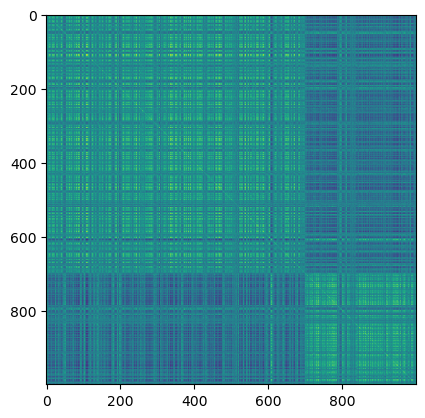

In [41]:
plt.imshow(german_comparisons)

In [42]:
G = np.zeros((2,2))

In [43]:
G[0,0] = np.mean(german_comparisons[:700,:700])
G[0,1] = np.mean(german_comparisons[:700,700:])
G[1,0] = np.mean(german_comparisons[700:,:700])
G[1,1] = np.mean(german_comparisons[700:,700:])

In [44]:
G

array([[0.5530673 , 0.4561018 ],
       [0.45490288, 0.56652648]])

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1876.21it/s]


Best at 396


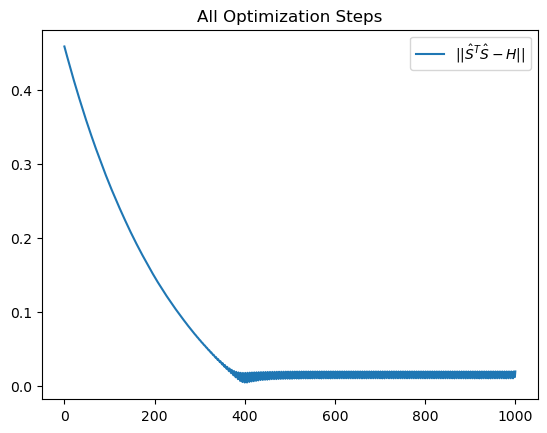

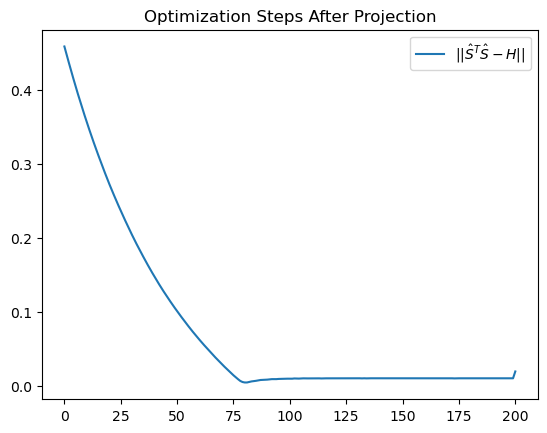

Final loss value: 0.019072859


In [45]:
S,loss = gradient_soft_labels(G, initialization_parameter = 0.75, penalty_constant=0.1, projection_type='shift_and_rescale', projection_frequency=5, norm_type='fro', learning_rate=0.001, iterations=1000, true_S = None, verbose = True)


In [46]:
np.dot(S.T,S)-G

array([[-0.0021579 , -0.0083673 ],
       [-0.00716838, -0.01286865]])

In [47]:
np.linalg.norm(np.dot(S.T,S)-G,ord='fro')

0.017077938756686815

In [48]:
S

tensor([[0.6595, 0.3362],
        [0.3405, 0.6638]])

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2019.40it/s]


Best at 396


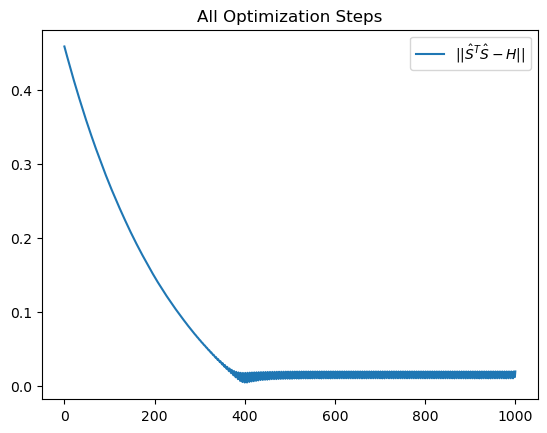

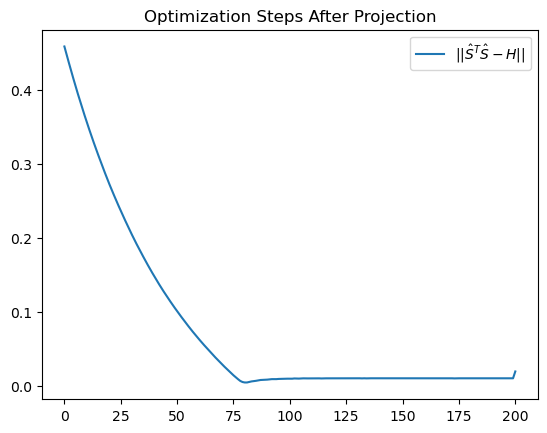

Final loss value: 0.019072859


In [49]:

best_S,loss = gradient_soft_labels(G, initialization_parameter = 0.75, penalty_constant=0.1, projection_type='shift_and_rescale', projection_frequency=5, norm_type='fro', learning_rate=0.001, iterations=1000, true_S = None, verbose = True)


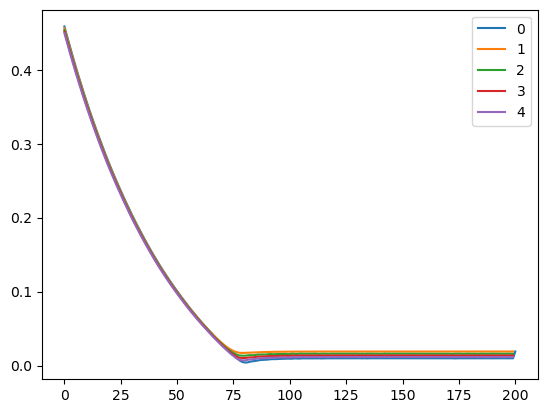

In [79]:
for i in range(5):
    plt.plot(loss[i::5],label = str(i))
plt.legend()
plt.show()

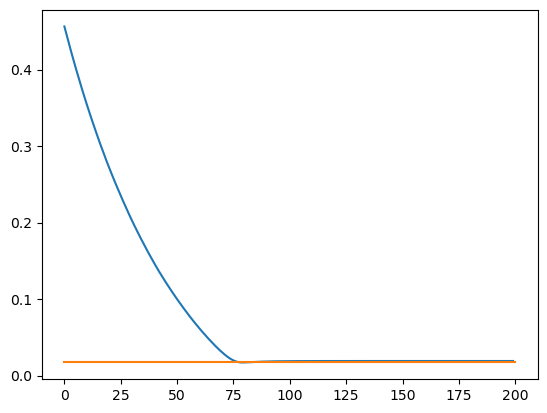

In [83]:
plt.plot(loss[1::5])
plt.plot([0,200],[0.01707794,0.01707794])
plt.show()

In [50]:
best_S

tensor([[0.6595, 0.3362],
        [0.3405, 0.6638]])

In [51]:
np.dot(best_S.T,best_S)-G

array([[-0.0021579 , -0.0083673 ],
       [-0.00716838, -0.01286865]])

In [52]:
np.linalg.norm(np.dot(best_S.T,best_S)-G,ord='fro')

0.017077938756686815

In [82]:
np.min(loss[1::5])

0.01707794

In [53]:
np.argmin(loss[1::5])

79

In [54]:
np.argmin(loss)

400

In [55]:
loss[396]

0.01707794

In [56]:
german_sorted_array[0].shape

(700, 60)

In [57]:
full_sorted = np.concatenate((german_sorted_array[0],german_sorted_array[1]))

In [58]:
full_sorted.shape

(1000, 60)

In [66]:
classifier_outputs = np.zeros((1000,2))

In [67]:
g_dataset = ut.Basic_Classification_Dataset(full_sorted)

In [68]:
g_loader = DataLoader(dataset = g_dataset, batch_size = 64, shuffle = False)

In [69]:
for bidx, batch in tqdm(enumerate(g_loader),total = len(g_loader)):
    #output = german(batch['inp'].to(device).float()).cpu().detach().numpy()[:,1]
    #print(output)
    classifier_outputs[bidx*64:(bidx+1)*64,:] = german(batch['inp'].to(device).float()).cpu().detach().numpy()

100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 1588.79it/s]


In [70]:
classifier_outputs

array([[0.38173071, 0.61826932],
       [0.10939956, 0.89060038],
       [0.17330468, 0.82669532],
       ...,
       [0.60860622, 0.39139375],
       [0.12849773, 0.87150222],
       [0.88085133, 0.1191487 ]])

In [71]:
S_c = np.empty((2,2))

In [72]:
S_c[0,0] =  np.mean(classifier_outputs[:700,1])
S_c[1,0] =  np.mean(classifier_outputs[:700,0])
S_c[0,1] =  np.mean(classifier_outputs[700:,1])
S_c[1,1] =  np.mean(classifier_outputs[700:,0])

In [73]:
S_c

array([[0.71229619, 0.27727224],
       [0.28770381, 0.72272776]])

In [75]:
junk = np.arange(20)

In [76]:
junk

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [77]:
junk[::5]

array([ 0,  5, 10, 15])

In [78]:
junk[1::5]

array([ 1,  6, 11, 16])

In [119]:
class nonrandom_MIMO_Dataset(Dataset):
    def __init__(self,in_set,set_index,selection = 'all'):
        '''
        Creates a data set that outputs two data points simultatneously.
        
        Inputs:
            in_set:  The data set with k classes from which data point are to be drawn.
            set_index:  Structure containing k numpy arrays each containing the index
                        of all elements of in_set corresponding to that class
            portion_same_class:  The portion of the time the data set will return
                                    two data points from the same class
            portion_different_class:  The portion of the time the data set will return
                                    two data points from different classes
                                    
        Note that the remaining portion of outputs 1 - (portion_same_class + portion_different_class)
        the data set will output two identical data points.
        '''
        self.in_set = in_set  
        self.set_index = set_index
        self.class_number = len(self.set_index)
        self.class_sizes =  np.array([len(i) for i in self.set_index])
        self.class_ends = np.cumsum(self.class_sizes)
        self.class_begins = np.roll(self.class_ends,1)
        self.class_begins[0] = 0
        self.item_shape = self.in_set[0][0].shape
        self.selection = selection
        if len(self.item_shape) > 1:
            self.output_shape = torch.Size([self.item_shape[0]*2])+self.item_shape[1:]
        else:
            self.output_shape = self.item_shape[0]*2
        self.half_output = self.item_shape[0]
        self.org_size = np.sum(self.class_sizes)
    
    def set_class(self,classes):
        self.selection = classes

    
    def __len__(self):
        if self.selection == 'all':
            return np.sum(self.class_sizes)**2
        else:
            return class_sizes[self.selection[0]]*class_sizes[self.selection[1]]
    
    def __getitem__(self, idx):
        inpt = torch.empty(self.output_shape)
        if self.selection == 'all':
            first_index = idx//self.org_size
            second_index = idx%self.org_size
            first_class = np.searchsorted(self.class_ends,first_index,side = 'right')
            first_inclass_index = first_index-self.class_begins[first_class]
            second_class = np.searchsorted(self.class_ends,second_index,side = 'right')
            second_inclass_index = second_index-self.class_begins[second_class]
        else:
            first_class = self.selection[0]
            second_class = self.selection[1]
            first_inclass_index = idx//class_sizes[self.selection[1]]
            second_inclass_index = idx%class_sizes[self.selection[1]]
            


        inpt[:self.half_output]=self.in_set[self.set_index[first_class][first_inclass_index]][0]
        inpt[self.half_output:]=self.in_set[self.set_index[second_class][second_inclass_index]][0]

        oupt = 1

        if first_class == second_class:
            oupt = 0


                
        return [inpt,oupt]